In [3]:
import os
import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, mean_absolute_error

# Define the datasets and their categories, metrics, and subcategories
dataset_mapping = {
    'Durum Wheat': ('Identification (I)', 'F1 Score', 'Crop Type'),
    'Soybean Seeds': ('Identification (I)', 'F1 Score', 'Crop Type'),
    'Mango Leaf Disease': ('Identification (I)', 'F1 Score', 'Disease Type'),
    'Bean Leaf Lesions': ('Identification (I)', 'F1 Score', 'Disease Type'),
    'DeepWeeds': ('Identification (I)', 'F1 Score', 'Pest Type'),
    'IP02': ('Identification (I)', 'F1 Score', 'Pest Type'),
    'SBRD': ('Identification (I)', 'F1 Score', 'Disease Stage'),
    'Yellow Rust 19': ('Classification (C)', 'NMAE', 'Disease Stage'),
    'FUSARIUM 22': ('Classification (C)', 'NMAE', 'Leaf Health'),
    'InsectCount': ('Quantification (Q)', 'NMAE', 'Pest Count'),
    'PlantDoc': ('Quantification (Q)', 'NMAE', 'Disease Quantification'),

}
result_table_dict={}
for this_shot in [0,1,2,4,8]:
    def calculate_metric(df, category, dataset_name):
        print(f"Processing {dataset_name}...")
        true_labels = df['1'].fillna('Unknown')
        pred_labels = df[f'# of Shots {this_shot}'].fillna('NA_placeholder')
        
        if category == 'Identification (I)':
            # Use F1 score for category I
            precision, recall, f1, _ = precision_recall_fscore_support(true_labels, pred_labels, average='weighted', zero_division=0)
            return f1 * 100
        elif category == 'Classification (C)':
            # Use normalized MAE for ordinal classification
            if dataset_name == 'FUSARIUM 22':
                ordinal_map = {
                    'Highly Resistant': 1,
                    'Resistant': 2,
                    'Moderately Resistant': 3,
                    'Susceptible': 4,
                    'Highly Susceptible': 5,
                }
            elif dataset_name == 'Yellow Rust 19':
                ordinal_map = {
                    'Resistant (R)': 1,
                    'Moderately Resistant (MR)': 2,
                    'MRMS': 3,
                    'Moderately Susceptible (MS)': 4,
                    'Susceptible (S)': 5,
                    'No disease (0)': 0,
                }
            else:
                raise ValueError(f"Unknown dataset for category C: {dataset_name}")
            
            # Add unseen labels to the ordinal map with the worst score
            max_value = max(ordinal_map.values())
            all_labels = set(true_labels).union(set(pred_labels))
            for label in all_labels:
                if label not in ordinal_map:
                    ordinal_map[label] = max_value + 1
            
            true_ordinal = true_labels.map(ordinal_map)
            pred_ordinal = pred_labels.map(ordinal_map)
            
            # Calculate normalized MAE
            mae = np.mean(np.abs(true_ordinal - pred_ordinal))
            max_possible_error = max(ordinal_map.values()) - min(ordinal_map.values())
            if max_possible_error == 0:
                print(f"Warning: All values are the same for {dataset_name}")
                return 0.0  # Perfect prediction if all values are the same
            normalized_mae = (mae / max_possible_error) * 100
            
            return normalized_mae
        elif category == 'Quantification (Q)':
            try:
                true_values = pd.to_numeric(true_labels, errors='coerce')
                pred_values = pd.to_numeric(pred_labels, errors='coerce')
                
                # Remove rows where either true_values or pred_values is NaN
                mask = ~(true_values.isna() | pred_values.isna())
                true_values = true_values[mask]
                pred_values = pred_values[mask]
                
                if len(true_values) == 0:
                    print(f"Warning: No valid numeric data for {dataset_name}")
                    return np.nan
                
                # Calculate MAPE (avoiding division by zero)
                non_zero_mask = true_values != 0
                if non_zero_mask.sum() == 0:
                    print(f"Warning: All true values are zero for {dataset_name}")
                    mape = np.nan
                else:
                    mape = np.mean(np.abs((true_values[non_zero_mask] - pred_values[non_zero_mask]) / true_values[non_zero_mask])) * 100
                
                # Calculate normalized MAE
                mae = np.mean(np.abs(true_values - pred_values))
                max_possible_error = true_values.max() - true_values.min()
                if max_possible_error == 0:
                    print(f"Warning: All values are the same for {dataset_name}")
                    normalized_mae = 0.0  # Perfect prediction if all values are the same
                else:
                    normalized_mae = (mae / max_possible_error) * 100
                
                return normalized_mae  # or return mape, depending on preference
            except Exception as e:
                print(f"Error in quantification for {dataset_name}: {str(e)}")
                return np.nan
    # Get the list of model folders
    model_folders = [f for f in os.listdir('results') if os.path.isdir(os.path.join('results', f))]

    # Initialize results dictionary
    results = {model: {} for model in model_folders}

    # Process each dataset for each model
    for model in model_folders:
        for dataset, (category, metric, subcategory) in dataset_mapping.items():
            try:
                df = pd.read_csv(f'results/{model}/{dataset}.csv', engine='python')
                result = calculate_metric(df, category, dataset)
                results[model][dataset] = result
            except FileNotFoundError:
                print(f"File not found: results/{model}/{dataset}.csv")
                results[model][dataset] = np.nan
            except Exception as e:
                print(f"Error processing {model}/{dataset}: {str(e)}")
                results[model][dataset] = np.nan

    # Create the result table
    result_table = pd.DataFrame(results).T  # Transpose to match the desired format

    # Rename the index and columns
    result_table.index.name = 'Model'
    result_table.columns.name = 'Dataset'

    # Round the results to 2 decimal places
    result_table = result_table.round(2)

    # Create multi-level columns
    columns = pd.MultiIndex.from_tuples([
        (category, metric, subcategory, dataset)
        for dataset, (category, metric, subcategory) in dataset_mapping.items()
    ])

    # Reorder and rename columns
    result_table = result_table.reindex(columns=columns.get_level_values(3))
    result_table.columns = columns

    print(result_table)
    result_table_dict[this_shot]=result_table.copy(deep= True)
    # Optionally, save the result table to a CSV file
    result_table.to_csv(f'analysis/plain-results/result_table_shot_{this_shot}.csv')

Processing Durum Wheat...
Processing Soybean Seeds...
Processing Mango Leaf Disease...
Processing Bean Leaf Lesions...
Processing DeepWeeds...
Processing IP02...
Processing SBRD...
Processing Yellow Rust 19...
Processing FUSARIUM 22...
Processing InsectCount...
Processing PlantDoc...
Processing Durum Wheat...
Processing Soybean Seeds...
Processing Mango Leaf Disease...
Processing Bean Leaf Lesions...
Processing DeepWeeds...
Processing IP02...
Processing SBRD...
Processing Yellow Rust 19...
Processing FUSARIUM 22...
Processing InsectCount...
Processing PlantDoc...
Processing Durum Wheat...
Processing Soybean Seeds...
Processing Mango Leaf Disease...
Processing Bean Leaf Lesions...
Processing DeepWeeds...
File not found: results/Claude-3.5-sonnet/IP02.csv
Processing SBRD...
Processing Yellow Rust 19...
Processing FUSARIUM 22...
Processing InsectCount...
Processing PlantDoc...
Processing Durum Wheat...
Processing Soybean Seeds...
Processing Mango Leaf Disease...
Processing Bean Leaf Lesio

In [5]:
# # GOOD. DON'T DELETE

import pandas as pd

# Assuming your DataFrame is called 'result_table'
result_table=result_table_dict[8]
def to_latex_with_multicolumn(df):
    latex = df.to_latex(multicolumn=True, multicolumn_format='c', multirow=True,
                        column_format='l' + 'c'*len(df.columns), 
                        float_format="{:0.2f}".format,
                        escape=False)
    
    # Remove the \toprule, \midrule, and \bottomrule commands
    latex = latex.replace('\\toprule', '\\hline')
    latex = latex.replace('\\midrule', '\\hline')
    latex = latex.replace('\\bottomrule', '\\hline')
    
    return latex

# Convert to LaTeX
latex_table = to_latex_with_multicolumn(result_table)

# Add caption and label
latex_table = """\\begin{table*}
\\centering
\\caption{8-shot Performance of Large Language Models on Agricultural Image Datasets}
\\label{tab:zero_shot_results}
\\resizebox{\\textwidth}{!}{%
""" + latex_table + "}\\end{table*}"

print(latex_table)



\begin{table*}
\centering
\caption{8-shot Performance of Large Language Models on Agricultural Image Datasets}
\label{tab:zero_shot_results}
\resizebox{\textwidth}{!}{%
\begin{tabular}{lccccccccccc}
\hline
 & \multicolumn{7}{c}{Identification (I)} & \multicolumn{2}{c}{Classification (C)} & \multicolumn{2}{c}{Quantification (Q)} \\
 & \multicolumn{7}{c}{F1 Score} & \multicolumn{2}{c}{NMAE} & \multicolumn{2}{c}{NMAE} \\
 & \multicolumn{2}{c}{Crop Type} & \multicolumn{2}{c}{Disease Type} & \multicolumn{2}{c}{Pest Type} & Disease Stage & Disease Stage & Leaf Health & Pest Count & Disease Quantification \\
 & Durum Wheat & Soybean Seeds & Mango Leaf Disease & Bean Leaf Lesions & DeepWeeds & IP02 & SBRD & Yellow Rust 19 & FUSARIUM 22 & InsectCount & PlantDoc \\
Model &  &  &  &  &  &  &  &  &  &  &  \\
\hline
GPT-4o & 100.00 & 43.34 & 91.43 & 96.66 & 42.65 & 19.56 & 59.87 & 12.67 & 23.33 & 11.33 & 18.64 \\
LLaVA v1.6 34B & 39.59 & 18.77 & 19.05 & 48.35 & 8.95 & 0.00 & 13.70 & 33.89 & 60.00 &

In [17]:
import pandas as pd

def to_latex_with_multicolumn(df):
    latex = df.to_latex(multicolumn=True, multicolumn_format='c', multirow=True,
                        column_format='llc' + 'c'*len(df.columns), 
                        float_format="{:0.2f}".format,
                        escape=False)

    # Remove the \toprule, \midrule, and \bottomrule commands
    latex = latex.replace('\\toprule', '\\hline')
    latex = latex.replace('\\midrule', '')
    latex = latex.replace('\\bottomrule', '\\hline')

    # Add \hline after each model (every two rows)
    lines = latex.split('\n')
    new_lines = []
    for i, line in enumerate(lines):
        new_lines.append(line)
        if i > 4 and (i - 3) % 2 == 0 and i < len(lines) - 2:  # Skip header and last line
            new_lines.append('\\hline')
    
    latex = '\n'.join(new_lines)

    return latex

# Combine 0-shot and 8-shot results
result_table_0 = result_table_dict[0]
result_table_8 = result_table_dict[8]

# Create a new index with Model and Shot
new_index = pd.MultiIndex.from_product([result_table_0.index, ['0-shot', '8-shot']], names=['Model', 'Shot'])

# Create a new DataFrame with the combined data
combined_data = []
for model in result_table_0.index:
    combined_data.append(result_table_0.loc[model].values)
    combined_data.append(result_table_8.loc[model].values)

combined_table = pd.DataFrame(combined_data, index=new_index, columns=result_table_0.columns)

# Convert to LaTeX
latex_table = to_latex_with_multicolumn(combined_table)

# Add caption and label
latex_table = r"""\begin{table}
\centering
\caption{0-shot and 8-shot Performance of Large Language Models on Agricultural Image Datasets}
\label{tab:combined_results}
\resizebox{\textwidth}{!}{%
""" + latex_table + "}\\end{table}"

print(latex_table)

\begin{table}
\centering
\caption{0-shot and 8-shot Performance of Large Language Models on Agricultural Image Datasets}
\label{tab:combined_results}
\resizebox{\textwidth}{!}{%
\begin{tabular}{llcccccccccccc}
\hline
 &  & \multicolumn{7}{c}{Identification (I)} & \multicolumn{2}{c}{Classification (C)} & \multicolumn{2}{c}{Quantification (Q)} \\
 &  & \multicolumn{7}{c}{F1 Score} & \multicolumn{2}{c}{NMAE} & \multicolumn{2}{c}{NMAE} \\
 &  & \multicolumn{2}{c}{Crop Type} & \multicolumn{2}{c}{Disease Type} & \multicolumn{2}{c}{Pest Type} & Disease Stage & Disease Stage & Leaf Health & Pest Count & Disease Quantification \\
 &  & Durum Wheat & Soybean Seeds & Mango Leaf Disease & Bean Leaf Lesions & DeepWeeds & IP02 & SBRD & Yellow Rust 19 & FUSARIUM 22 & InsectCount & PlantDoc \\
\hline
Model & Shot &  &  &  &  &  &  &  &  &  &  &  \\

\hline
\multirow[t]{2}{*}{GPT-4o} & 0-shot & 59.24 & 23.96 & 62.74 & 80.26 & 24.21 & 19.61 & 44.14 & 20.00 & 32.50 & 32.00 & 39.92 \\
 & 8-shot & 100.00 &

In [30]:
# def generate_latex_table(df):
#     latex = """\\begin{table*}
# \\centering
# \\caption{Zero-shot Performance of Large Language Models on Agricultural Image Datasets}
# \\label{tab:zero_shot_results}
# \\resizebox{\\textwidth}{!}{%
# \\begin{tabular}{|l|*{10}{c|}}
# \\hline
# \\multicolumn{1}{|c|}{} & \\multicolumn{7}{c|}{Identification (I)} & \\multicolumn{2}{c|}{Classification (C)} & \\multicolumn{1}{c|}{Quantification (Q)} \\\\ 
# \\multicolumn{1}{|c|}{} & \\multicolumn{7}{c|}{F1 Score} & \\multicolumn{2}{c|}{MAE} & \\multicolumn{1}{c|}{MAE} \\\\ 
# \\cline{2-11}
# \\multicolumn{1}{|c|}{} & \\multicolumn{2}{c|}{Crop Type} & \\multicolumn{2}{c|}{Disease Type} & \\multicolumn{2}{c|}{Pest Type} & Disease Stage & Disease Stage & Leaf Health & Pest Count \\\\ 
# \\cline{2-11}
# Model & Durum Wheat & Soybean Seeds & Mango Leaf Disease & Bean Leaf Lesions & DeepWeeds & IP02 & SBRD & Yellow Rust 19 & FUSARIUM 22 & InsectCount \\\\ 
# \\hline
# """
    
#     for _, row in df.iterrows():
#         latex += f"{row.name} & " + " & ".join(f"{x:.2f}" if isinstance(x, float) else str(x) for x in row) + " \\\\ \n\\hline\n"

#     latex += """\\end{tabular}
# }
# \\end{table*}"""

#     return latex

# # Assuming your DataFrame is called 'result_table'
# latex_table = generate_latex_table(result_table)
# print(latex_table)

\begin{table*}
\centering
\caption{Zero-shot Performance of Large Language Models on Agricultural Image Datasets}
\label{tab:zero_shot_results}
\resizebox{\textwidth}{!}{%
\begin{tabular}{|l|*{10}{c|}}
\hline
\multicolumn{1}{|c|}{} & \multicolumn{7}{c|}{Identification (I)} & \multicolumn{2}{c|}{Classification (C)} & \multicolumn{1}{c|}{Quantification (Q)} \\ 
\multicolumn{1}{|c|}{} & \multicolumn{7}{c|}{F1 Score} & \multicolumn{2}{c|}{MAE} & \multicolumn{1}{c|}{MAE} \\ 
\cline{2-11}
\multicolumn{1}{|c|}{} & \multicolumn{2}{c|}{Crop Type} & \multicolumn{2}{c|}{Disease Type} & \multicolumn{2}{c|}{Pest Type} & Disease Stage & Disease Stage & Leaf Health & Pest Count \\ 
\cline{2-11}
Model & Durum Wheat & Soybean Seeds & Mango Leaf Disease & Bean Leaf Lesions & DeepWeeds & IP02 & SBRD & Yellow Rust 19 & FUSARIUM 22 & InsectCount \\ 
\hline
GPT-4o & 59.24 & 23.96 & 62.74 & 80.26 & 24.21 & 19.61 & 25.06 & 1.00 & 1.30 & nan \\ 
\hline
LLaVA v1.6 34B & 30.45 & 28.19 & 15.59 & 51.21 & 8.73 & 0.

In [49]:
result_table.head()

Identification (I)                                   \
                           F1 Score                                    
                          Crop Type                     Disease Type   
                        Durum Wheat Soybean Seeds Mango Leaf Disease   
Model                                                                  
GPT-4o                       100.00         43.34              91.43   
LLaVA v1.6 34B                39.59         18.77              19.05   
Gemini-flash-1.5              60.00         36.00              68.63   
Claude-3-haiku                59.67         45.60              42.29   
Claude-3-sonnet               65.81         42.69              45.21   

                                                                   \
                                                                    
                                   Pest Type        Disease Stage   
                 Bean Leaf Lesions DeepWeeds   IP02          SBRD   
Model                                                               
GPT-4o                       96.66     42.65  19.56         57.78   
LLaVA v1.6 34B               48.35      8.95   0.00         13.70   
Gemini-flash-1.5             86.92     36.11  25.47         43.70   
Claude-3-haiku               55.41     30.95    NaN         16.90   
Claude-3-sonnet              63.79      4.69    NaN         17.06   

                 Classification (C)             Quantification (Q)  
                                MAE                            MAE  
                      Disease Stage Leaf Health         Pest Count  
                     Yellow Rust 19 FUSARIUM 22        InsectCount  
Model                                                               
GPT-4o                         0.63        0.93                NaN  
LLaVA v1.6 34B                 2.03        3.00                NaN  
Gemini-flash-1.5               1.10        0.67                NaN  
Claude-3-haiku                 1.80        0.83                NaN  
Claude-3-sonnet                1.37         NaN                NaN

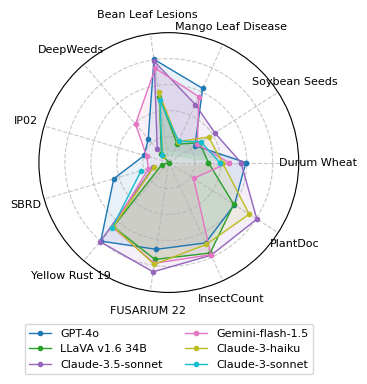

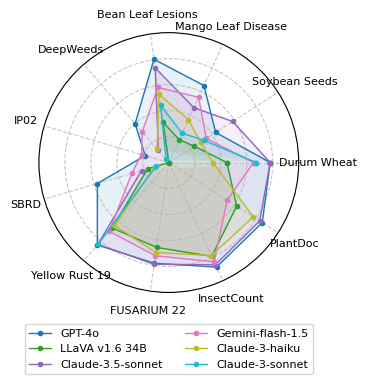

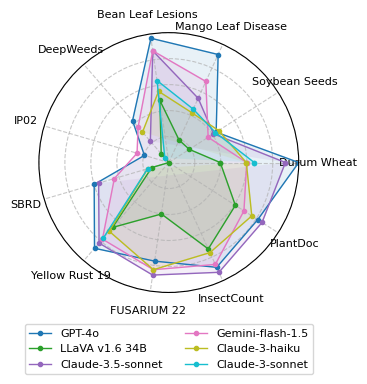

In [20]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

for shot in [0,2,8]:
    # Assuming result_table is already defined as per your provided data
    result_table=result_table_dict[shot]
    # Prepare the data
    models = result_table.index.tolist()
    datasets = result_table.columns.get_level_values(3).tolist()
    metrics = result_table.columns.get_level_values(1).tolist()
    values = result_table.values

    # Normalize the values based on the metric
    normalized_values = np.zeros_like(values)
    for i, metric in enumerate(metrics):
        # normalized_values[:, i] = values[:, i]
        if metric == 'F1 Score':
            normalized_values[:, i] = values[:, i] 
        elif metric == 'NMAE':
            normalized_values[:, i] = 100-values[:, i]

    # Remove columns with all NaN values
    valid_columns = ~np.all(np.isnan(normalized_values), axis=0)
    normalized_values = normalized_values[:, valid_columns]
    datasets = [d for d, v in zip(datasets, valid_columns) if v]

    # Set up the angles for each dataset
    angles = np.linspace(0, 2*np.pi, len(datasets), endpoint=False)

    # Close the plot by appending the first value to the end
    normalized_values = np.concatenate((normalized_values, normalized_values[:, [0]]), axis=1)
    angles = np.concatenate((angles, [angles[0]]))

    # Set up the plot
    fig, ax = plt.subplots(figsize=(5, 4), subplot_kw=dict(projection='polar'))

    # Color cycle for the models
    colors = plt.cm.tab10(np.linspace(0, 1, len(models)))
    ax.set_ylim(0, 100)  # Set the range from 0 to 100

    # Plot each model
    for i, model in enumerate(models):
        ax.plot(angles, normalized_values[i], 'o-', linewidth=1, color=colors[i], label=model, markersize=3)
        ax.fill(angles, normalized_values[i], alpha=0.1, color=colors[i])

    # Set the labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(datasets, fontsize=8)

    # Remove radial labels and set grid
    ax.set_yticklabels([])
    ax.grid(True, linestyle='--', alpha=0.7)

    # Adjust the subplot layout
    plt.subplots_adjust(bottom=0.1, top=0.9)

    # Create legend
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fontsize=8, ncol=2)

    # Adjust layout and save
    plt.tight_layout()
    plt.savefig(f'analysis/radar_plots/{shot}.pdf', dpi=300, bbox_inches='tight')
    plt.show()

In [39]:
result_table_dict[0].head()

Identification (I)                                   \
                           F1 Score                                    
                          Crop Type                     Disease Type   
                        Durum Wheat Soybean Seeds Mango Leaf Disease   
Model                                                                  
GPT-4o                        59.24         23.96              62.74   
LLaVA v1.6 34B                30.45         28.19              15.59   
Gemini-flash-1.5              46.18         26.12              55.71   
Claude-3-haiku                41.27         36.41              17.59   
Claude-3-sonnet               39.25         29.44              18.07   

                                                                   \
                                                                    
                                   Pest Type        Disease Stage   
                 Bean Leaf Lesions DeepWeeds   IP02          SBRD   
Model                                                               
GPT-4o                       80.26     24.21  19.61         44.14   
LLaVA v1.6 34B               51.21      8.73   0.00          5.56   
Gemini-flash-1.5             73.33     39.14  17.81         16.30   
Claude-3-haiku               54.73      6.95    NaN         12.06   
Claude-3-sonnet              48.29      7.77    NaN         22.22   

                 Classification (C)             Quantification (Q)  \
                               NMAE                           NMAE   
                      Disease Stage Leaf Health         Pest Count   
                     Yellow Rust 19 FUSARIUM 22        InsectCount   
Model                                                                
GPT-4o                        20.00       32.50               32.0   
LLaVA v1.6 34B                34.67       24.67                NaN   
Gemini-flash-1.5              34.00       21.67               22.0   
Claude-3-haiku                34.67       20.83                NaN   
Claude-3-sonnet               33.33         NaN                NaN   

                                         
                                         
                 Disease Quantification  
                               PlantDoc  
Model                                    
GPT-4o                            39.92  
LLaVA v1.6 34B                      NaN  
Gemini-flash-1.5                  77.40  
Claude-3-haiku                      NaN  
Claude-3-sonnet                     NaN

# individual plots for each dataset

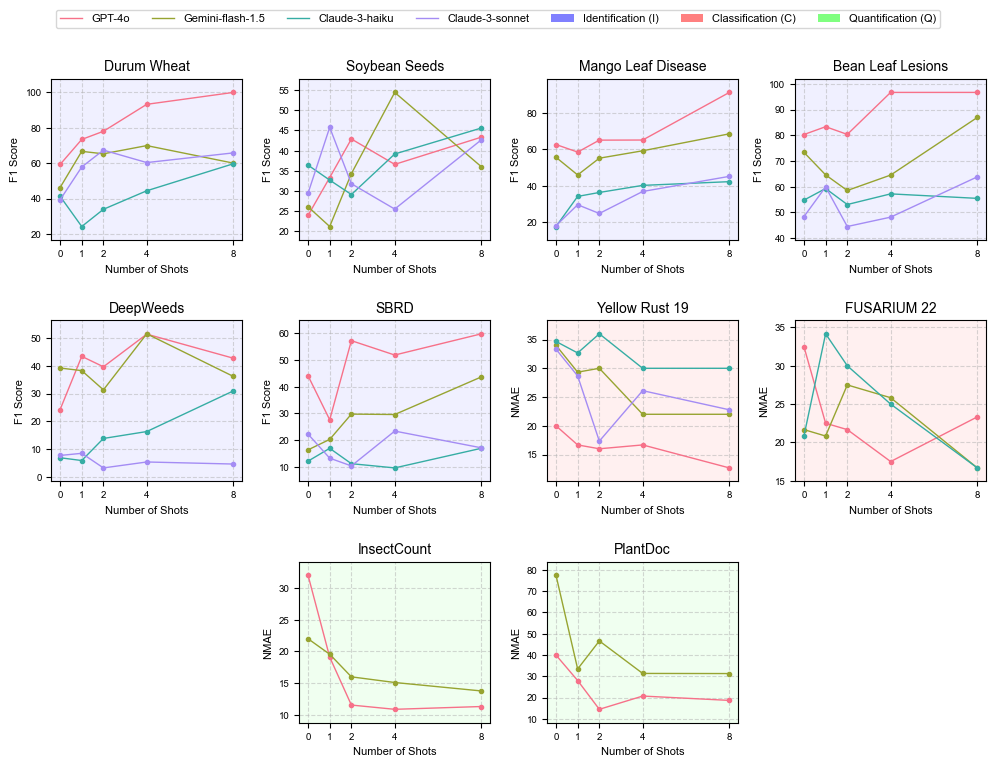

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

# Set up the plot style
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 8,
    'axes.labelsize': 9,
    'axes.titlesize': 10,
    'xtick.labelsize': 7,
    'ytick.labelsize': 7,
    'legend.fontsize': 8,
})

# Prepare data
shots = [0, 1, 2, 4, 8]
models = [model for model in result_table_dict[0].index if model != 'LLaVA v1.6 34B']
datasets = [dataset for dataset in result_table_dict[0].columns if dataset[3] != 'IP02']

# Set up the grid
n_datasets = len(datasets)
n_cols = 4
n_rows = math.ceil(n_datasets / n_cols)

# Create the main figure
fig = plt.figure(figsize=(10, 2.5 * n_rows))

# Use GridSpec for more control over subplot positioning
gs = gridspec.GridSpec(n_rows, n_cols)

# Color palette for models
model_colors = sns.color_palette("husl", n_colors=len(models))

# Background colors for problem types (subtle for subplots)
bg_colors = {
    'Identification (I)': '#f0f0ff',
    'Classification (C)': '#fff0f0',
    'Quantification (Q)': '#f0fff0'
}

# Intense colors for problem types (for legend)
legend_colors = {
    'Identification (I)': '#8080ff',
    'Classification (C)': '#ff8080',
    'Quantification (Q)': '#80ff80'
}

# Plot each dataset
for i, dataset in enumerate(datasets):
    row = i // n_cols
    col = i % n_cols
    
    # Center the plots in the last row
    if row == n_rows - 1:
        n_plots_last_row = n_datasets - (n_rows - 1) * n_cols
        offset = (n_cols - n_plots_last_row) // 2
        ax = fig.add_subplot(gs[row, col + offset])
    else:
        ax = fig.add_subplot(gs[row, col])
    
    ax.set_facecolor(bg_colors[dataset[0]])
    
    all_values = []
    for j, model in enumerate(models):
        values = [result_table_dict[shot].loc[model, dataset] for shot in shots]
        all_values.extend(values)
        ax.plot(shots, values, marker='o', markersize=3, linewidth=1, color=model_colors[j])
    
    ax.set_title(f'{dataset[3]}', fontsize=10)
    ax.set_xlabel('Number of Shots', fontsize=8)
    ax.set_ylabel(dataset[1], fontsize=8)
    ax.tick_params(axis='both', which='major', labelsize=7)
    
    # Set y-axis limits dynamically
    y_min, y_max = min(all_values), max(all_values)
    y_range = y_max - y_min
    ax.set_ylim(y_min - 0.1 * y_range, y_max + 0.1 * y_range)

    # Add grid lines
    ax.grid(True, linestyle='--', alpha=0.5)
    
    # Set x-axis ticks
    ax.set_xticks(shots)

# Create a custom legend
legend_elements = [plt.Line2D([0], [0], color=model_colors[i], lw=1, label=model) 
                   for i, model in enumerate(models)]

# Add problem type legend with intense colors
problem_type_patches = [mpatches.Patch(facecolor=color, edgecolor='none', label=ptype) 
                        for ptype, color in legend_colors.items()]
legend_elements.extend(problem_type_patches)

fig.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(0.5, 1.02), 
           ncol=len(models) + len(bg_colors), fontsize=8)

# Adjust the layout
plt.tight_layout()
plt.subplots_adjust(top=0.92, hspace=0.5, wspace=0.3)  # Make room for the legend and adjust spacing

# Show the plot
plt.show()